# Bayesian Network
* * *
### Objective
In this Jupyter notebook, we build a stochastic generator of hourly electricity use in a residential building from measured data.  
This model can be used to generate many synthetic profiles of a given length as required by a Monte Carlo analysis.  
In this way a sensitivity analysis or robust optimization of Energy Hub outputs can be performed.

The data used comes from [The Hourly Usage of Energy Dataset for Buildings in British Columbia](https://summit.sfu.ca/item/18163), which is available for free for non-commercial educational purposes.

This notebook is organized as follows:
- [Introduction](#Introduction) gives an overview of the approach and model formulation.
- [Data loading and pre-processing](#Data-loading-and-pre-processing) performs the required initial actions on the measured data to obtain a proper data set for the model fitting.
- [Conditional probability function fitting](#Conditional-probability-function-fitting) computes $P(U_t=u|M_t, H_t, W_t)$ from the measured data.
- [Yearly profile generation](#Yearly-profile-generation) shows how using the model to generate profiles.
- [Performance check](#Performance-check) proposes different tools to assess the similarities between synthetic and measured profiles.
* * *

In [1]:
import os
import pandas as pd
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.dates as mdates

import chaospy as cp # Uncertainty quantification using polynomial chaos expansions and Monte Carlo methods, and tools and classes to play with distributions
import scipy.fftpack as fft # Fourier transform

# Introduction
Buildings, renewable energy generation, storage technologies and associated energy systems all pose complex, interacting design and operational challenges. These are characterized by the underlying variation in boundary conditions, primarily the fluctuations in climate that affect solar and wind availability and thermal loads, but also the occupancy and use patterns of buildings and rooms. This work proposes a simple way to apply mathematical stochastic modelling techniques to these problems.

The idea is to build a stochastic profile generator from measured data to obtain synthetic hourly electricity demand of a residential building over a year. This generator will be used as input of [Energy Hub models](../EnergyHub/Overview.ipynb) and will be the first piece of a stochastic formulation of the Energy Hub problem.

This notebook is a first attempt to build such a generator by means of a simple [Bayesian network](https://en.wikipedia.org/wiki/Bayesian_network).  
The proposed Bayesian network to predict the electricity use for the hour t is the following:<br>
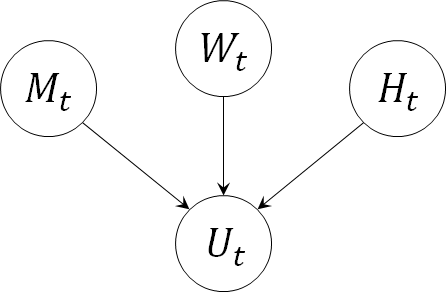
- U: electricity use (kW)
- M: month in the year [1:12]
- H: hour of the day [0:23]
- W: weekday/weekend (0 or 1)

In other words, we assume that the electricity use of hour t is only dependant on the month of the year, the hour of the day and wether the day is a weekday or a weekend.  
The electricity use is a stochastic variable and so we can define its probability as:
$$P(U_t=u)=P(U_t=u|M_t, H_t, W_t)$$

# Data loading and pre-processing
## Loading
The data set of the building is saved as csv file whose name contains its id in HUE study.  
It is an appartment in Metro Vancouver area, equipped with an electric in-floor radiant heating.  
The DataFrame is formatted to have the date as the index and one column which contains the total electricity demand for the past hour in kWh. There are also some missing values (0.4% of all the values) which are removed from the data set.
The time step is therefore one hour.

In [2]:
pathData = '' # relative path to data
dataid = 22 # Building id

# Load data for the building
df = pd.read_csv(os.path.join(pathData, 'Residential_' + str(dataid) + '.csv'))

# Format the index of the dataframe so it is the date
df.index = pd.to_datetime(df['date'])
df.index = df.index + pd.to_timedelta(df.hour, unit='h')
building = df.drop(columns=['date', 'hour'])

# Rename the column
building = building.rename(columns = {'energy_kWh':'use'})

# Remove the missing values (Nans)
building = building.dropna()
    
# Show the first lines of the DataFrame
building.head()

,use
2016-06-29 00:00:00,0.09
2016-06-29 01:00:00,0.09
2016-06-29 02:00:00,0.09
2016-06-29 03:00:00,0.09
2016-06-29 04:00:00,0.09


## Pre-processing
Three columns are added to the DataFrame to facilitate model fitting:
- *month*: an integer between 1 and 12 corresponding to the current month
- *hourOfDay*: an integer between 0 and 23 corresponding to the current hour of the day
- *isWeekday*: whether the current day is a weekday ($isWeekday=1$) or not ($isWeekday=0$).

In [3]:
# Add a column for the month number
month = building.index.month
building["month"] = month

# Add a column for the hour in day number
hourOfDay = building.index.hour
building["hourOfDay"] = hourOfDay

# Add a column for the type of day (weekday=1, weekend=0)
dayOfWeek = building.index.weekday
isWeekday = np.zeros_like(dayOfWeek)
isWeekday[dayOfWeek<4] = 1
building["isWeekday"] = isWeekday

# Show the first lines of the DataFrame
building.head()

,use,month,hourOfDay,isWeekday
2016-06-29 00:00:00,0.09,6,0,1
2016-06-29 01:00:00,0.09,6,1,1
2016-06-29 02:00:00,0.09,6,2,1
2016-06-29 03:00:00,0.09,6,3,1
2016-06-29 04:00:00,0.09,6,4,1


# Conditional probability function fitting
The idea here is to compute $P(U_t=u|M_t, H_t, W_t)$ from the measured data.  
Taking advantage of the fact that $M_t$, $H_t$ and $W_t$ are discrete and countable, it equates to learn a probability density function per triple $(M_t, H_t, W_t)$.  
We will therefore learn $12*24*2= \color{blue}{576}$ distributions!

In [4]:
# Create the empty arrays
distributions = np.empty([12,24,2], dtype=object)
samplesNumber = np.zeros_like(distributions)

# Compute the distributions
for k, g in building.groupby(building.month):   # group by month and loop
    for k1, g1 in g.groupby(g.hourOfDay):       # group by hour of day and loop
        for k2, g2 in g1.groupby(g1.isWeekday): # group by type of day and loop
            # Fit one distribution for each month (k-1), each hour of day k1, each type of day k2
            distributions[k-1,k1,k2] = cp.SampleDist(g2.use) # actual fitting function from chaospy
            # Number of samples used for fitting each distribution
            samplesNumber[k-1,k1,k2] = len(g2)

# Print some information about the number of samples used for the distributions
print("Minimum number of samples for a distribution: " + str(samplesNumber.min()))
print("Maximum number of samples for a distribution: " + str(samplesNumber.max()))

# Save distributions
with open("Models\\NaiveBayesianDistributions_" + str(dataid), "wb") as fp:
    pk.dump(distributions, fp)

Minimum number of samples for a distribution: 16
Maximum number of samples for a distribution: 38


It is interesting to first examine the proability density functions obtained.  
Two figures are generated:
- one containing all 576 density functions in one plot,
- one representing the monthly evolution of the density functions for each type of day and each hour of day.

Text(6, 7, 'Weekend')

/home/evan/.local/lib/python3.6/site-packages/IPython/core/events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)


/home/evan/.local/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


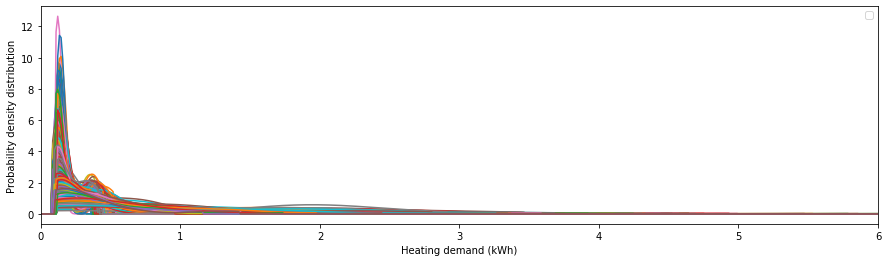

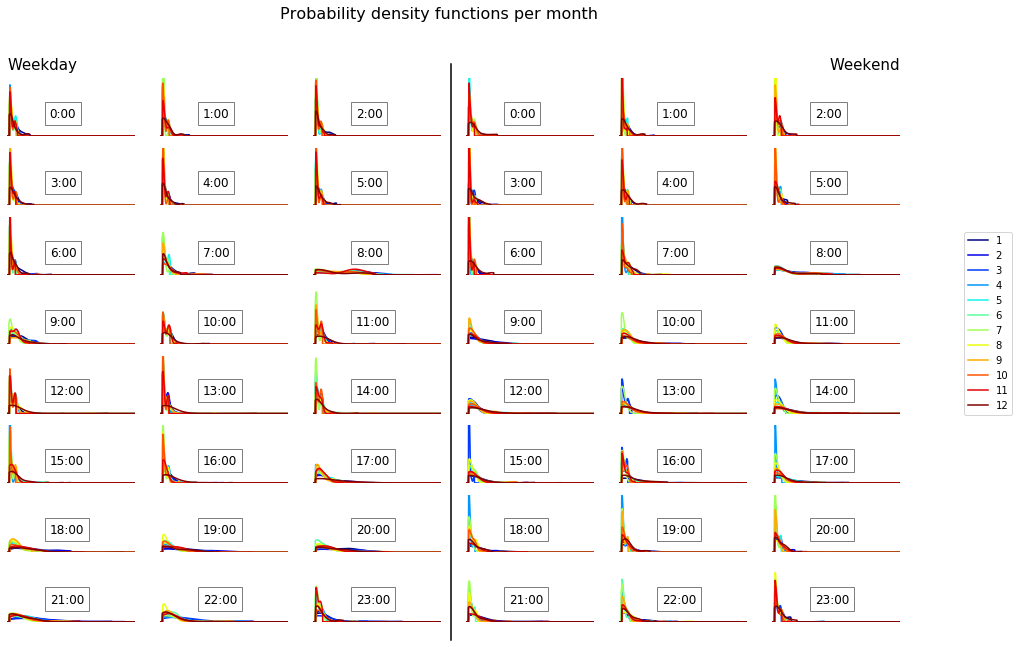

In [5]:
# Set the x-axis values for the evaluation of the functions (electricity use)
use = np.linspace(0, 6, 500)
# Set the different colors for the months
colors = pl.cm.jet(np.linspace(0,1,12))

# Prepare figures and subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 4)) # a global plot
fig1, ax1 = plt.subplots(8, 6, figsize=(16, 10)) # plots to compare month, hour of day and type of day
# One set of axis per type of day
ax1a = ax1[:,:3].reshape(24)
ax1b = ax1[:,3:].reshape(24)

# For-loop to loop over the distributions array
for i in np.arange(12):        # loop over months
    p = 0
    for j in np.arange(24):    # loop over hours of day
        for k in np.arange(2): # loop over types of day
            ax.plot(use, distributions[i,j,k].pdf(use))
        ax1a[p].plot(use, distributions[i,j,1].pdf(use), label=i+1, color=colors[i])
        ax1b[p].plot(use, distributions[i,j,0].pdf(use), label=i+1, color=colors[i])
        p = p+1

# Formatting the global plot
ax.set_xlim([0,6])
ax.set_xlabel('Heating demand (kWh)')
ax.set_ylabel('Probability density distribution')
ax.legend()

# Formatting the second figure
# Formatting each subplot
for p in np.arange(24):
    ax1a[p].set_xlim([0,6])
    ax1a[p].set_ylim([0,6])
    ax1a[p].axis('off')
    ax1a[p].text(2, 2, str(p)+':00', fontsize=12, bbox={'facecolor': 'white','alpha': 0.5, 'pad': 5})
    ax1b[p].set_xlim([0,6])
    ax1b[p].set_ylim([0,6])
    ax1b[p].axis('off')
    ax1b[p].text(2, 2, str(p)+':00', fontsize=12, bbox={'facecolor': 'white','alpha': 0.5, 'pad': 5})
# Add a line between subplots for weekday and weekend
line = plt.Line2D([0.51,0.51],[0.1,0.9], transform=fig1.transFigure, color="black")
fig1.add_artist(line)
# Add a global legend
handles, labels = ax1a[0].get_legend_handles_labels()
fig1.legend(handles, labels, loc='center right')
# Add title and subtitles
fig1.suptitle("Probability density functions per month",fontsize=16)
ax1a[0].text(0,7,'Weekday',fontsize=15)
ax1b[2].text(6,7,'Weekend',fontsize=15, horizontalalignment='right')

<font color=green>Comments:</font>
- Globally we observe a high probability of an electricity demand of around 0.2 kWh. There is also a rapid decrease of the density functions below 0.1 kWh which seems to indicate that this is the base load of this building. We can also observe a second peak around 0.4 kWh which can correspond to the operation of the electric in-floor radiant heating.
- Weekends are usually characterized by a slightly higher diversity of the demand during the morning (less sharped peaks) and less diversity during end of afternoon and evening. The main differences between weekday and weekend occur during the working hours and evenings (7:00-23:00).
- Vancouver (British Columbia, Canada) is characterized by a mild winter and a mild summer. It seems that this house does not have a cooling device as electricity demand is generally higher in winter (because of the in-floor heating). Indeed, we can observe a spread and a shift of the peak towards higher values of electricity demand for winter months. This tendency is more pronounced during the end of the night, indicating that when people are awake the other appliance energy demand is high compared to the one of the heating device.

# Yearly profile generation
This section shows how to use the model to generate hourly electricity demand for one year.  
The final profile will be stochastic (i.e. different for each run).  
The general procedure is as follows:

- Create a DataFrame with hours for one year as the index and corresponding *month*, *hourOfDay* and *isWeekday* values.
- For each row (i.e. each hour), generate an electricity demand value from the corresponding proability density function.

**Remarks:**
- The proposed procedure can generate several profiles at the same time (here 10), to enable sampling of the distributions.  
The sampling method can be changed through the parameters of the *sample* function (see [chaospy documentation](https://chaospy.readthedocs.io/en/development/distributions/sampling.html) for further information).
- An array is first populated before populating the DataFrame for computationally efficiency.

In [6]:
### Number of profiles to generate
nb_profile = 10
##

## Create the base dataFrame
profiles = pd.DataFrame(index=pd.date_range(start='1/1/2019', end='1/1/2020', freq="H"))
# Add a column for the month number
month = profiles.index.month
profiles["month"] = month
# Add a column for the hour in day number
hourOfDay = profiles.index.hour
profiles["hourOfDay"] = hourOfDay
# Add a column for the type of day (weekday=1, weekend=0)
dayOfWeek = profiles.index.weekday
isWeekday = np.zeros_like(dayOfWeek)
isWeekday[dayOfWeek<4] = 1
profiles["isWeekday"] = isWeekday

## Populate with Bayesian network model
# Create data in a table
tab_profiles = []
for index, time in profiles.iterrows(): # loop over the rows of the DataFrame
    # add electricity demand for all the profiles for this time, using samplig method
    tab_profiles.append( distributions[time.month-1, time.hourOfDay, time.isWeekday].sample(nb_profile) )
tab_profiles = np.array(tab_profiles)

## Create new columns
for p in np.arange(nb_profile):
    profiles['use'+str(p)] = tab_profiles[:,p]
profiles.head()

,month,hourOfDay,isWeekday,use0,use1,use2,use3,use4,use5,use6,use7,use8,use9
2019-01-01 00:00:00,1,0,1,0.157240,0.693348,0.705083,0.614764,0.446150,0.050476,0.041904,0.367458,0.027921,-0.129056
2019-01-01 01:00:00,1,1,1,0.302909,0.026112,0.654659,0.247078,0.418450,0.392901,0.613000,0.136826,0.475260,-0.118658
2019-01-01 02:00:00,1,2,1,0.086802,0.167453,0.244231,1.039209,0.705037,-0.013492,0.228723,0.045974,0.282636,-0.071241
2019-01-01 03:00:00,1,3,1,1.108061,0.233207,0.406656,0.180227,0.242628,0.429871,0.189378,0.170201,-0.114581,0.034578
2019-01-01 04:00:00,1,4,1,0.439990,0.128494,0.253502,0.730685,0.579208,-0.018063,1.015658,0.332715,-0.061707,1.098958


Let's have a quick look to the resulting profiles:

/home/evan/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Date')

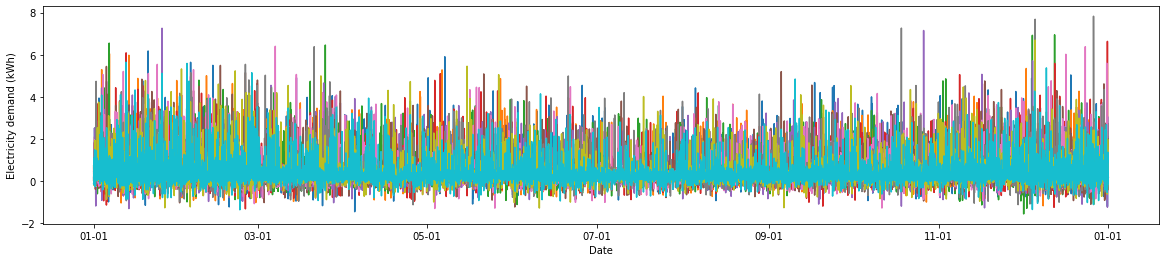

In [7]:
# Create the figure
fig, ax = plt.subplots(1, 1, figsize=(20, 4))
# Plot all the synthetic profiles on the same plot
for p in np.arange(nb_profile):
    ax.plot(profiles.index, profiles['use'+str(p)])
# Format the dates for x-axis
myFmt = mdates.DateFormatter('%m-%d')
ax.xaxis.set_major_formatter(myFmt)
# Add labels
ax.set_ylabel('Electricity demand (kWh)')
ax.set_xlabel('Date')

We can see that the profiles are all different, but seem to have retained the underlying trends seen in the original data.  
We will get a better idea of whether the synthetic profiles retain the correct statistical properties in the next section.

# Performance check

Assessing the performance of a stochastic model can be tricky.  
Here we propose several basic ways, but better metrics can be found.  
These approaches are based on the comparison of several features:
- distribution of total annual demands,
- evolution and distribution of daily demands,
- autocorrelation for a given time series,
- discrete Fourier transform of the time series.

## Total annual demands
Comparing the distribution of the annual demands enables us to check that the model reproduces the overall annual variations over the 3 years present in the  measured data.  
Yearly demands are computed and plotted on a 1-D graph.

In [8]:
# Sum the synthetic demand over the year for each profile (=each column)
synthYearUse = profiles.iloc[:,3:].sum()

# We need a complete data set to compute the different checks.
# Interpolation for missing values
buildingComplete = building.copy()
buildingComplete = buildingComplete.resample('1H').sum()
buildingComplete.interpolate()
# Compute the measured yearly demand for each year
measYearUse = []
for k, g in buildingComplete.groupby(buildingComplete.index.year): # group by year and loop
    if len(g) >= 8760: # only complete years
        # sum the demand over the year
        measYearUse.append(g.use.sum())

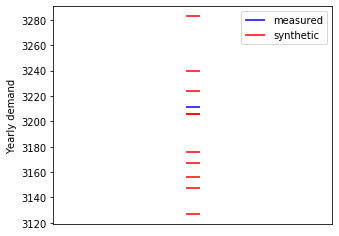

In [9]:
# Plot the results
# Create the figure
fig1, ax1 = plt.subplots(1, 1, figsize=(5, 4))
# Plot the yearly demands as events (= 1D graph)
ax1.eventplot(measYearUse, orientation='vertical', lineoffsets=0, colors='b', label="measured")
ax1.eventplot(synthYearUse, orientation='vertical', lineoffsets=0, colors='r', label="synthetic")
# Format the figure
ax1.set_xlim([-10,10])
ax1.axes.get_xaxis().set_visible(False)
ax1.set_ylabel('Yearly demand')
ax1.legend()

<font color=green>Comments:</font>
- Unfortunately the data set contains only one whole year so it is hard to derive a lot of useful information. We can only say that the measured yearly demand is on the same order of magnitude as the synthetic ones.

## Daily demand
Increasing the granularity, we can compare the daily demands and their evolution over the year.  
Daily demands are computed and plotted against day of the year.

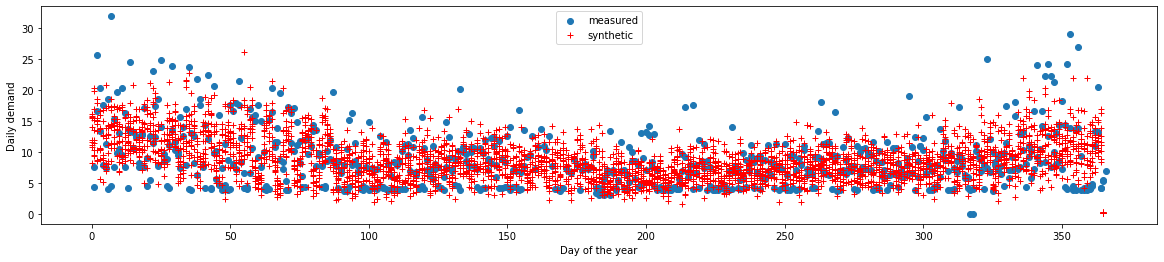

In [10]:
# Compute the measured daily demands
# Create list of days of year
synthDayOfYear = np.arange(366)
# Create empty list
synthDayUse = []
for k, g in profiles.groupby(profiles.index.date): # group by date and loop
    # Sum demands over the day
    # The final shape of synthDayUse is (366, nb_profile)
    synthDayUse.append(g.sum()[3:])

# Compute the measured daily demands
# Create empty lists
measDayOfYear = []
measDayUse = []
for k, g in buildingComplete.groupby(buildingComplete.index.date): # group by date and loop
    if len(g) >= 24: #only complete days
        # Store day of year for plotting
        measDayOfYear.append(g.index[0].dayofyear)
        # Sum demands over the day
        # The final shape of measDayUse is (, len(building))
        measDayUse.append(g.use.sum())
        
# Plot the results
# Create the figure
fig1, ax1 = plt.subplots(1, 1, figsize=(20, 4))
# Plot the daily demands as scatter plot
line1 = ax1.scatter(measDayOfYear, measDayUse)
lines2 = ax1.plot(synthDayOfYear, synthDayUse, 'r+')
# Format the figure
ax1.set_xlabel('Day of the year')
ax1.set_ylabel('Daily demand')
ax1.legend([line1, lines2[0]],["measured","synthetic"])

<font color=green>Comments:</font>
- The trend over the year is very well reproduced.
- The variability of synthetic data is a bit lower. The model seems to be too conservative. This could also come from the sampling method.

## Autocorrelation
Electricity demand time series can have high autocorrelation due to repeating patterns.  
Autocorrelation plots highlight the time constants of the main patterns.
As we also search for yearly autocorrelation (because of the yearly trend seen above), it is necessary to create an artificial data set over several years from the synthetic profiles. This is done by concatenating all the profiles.

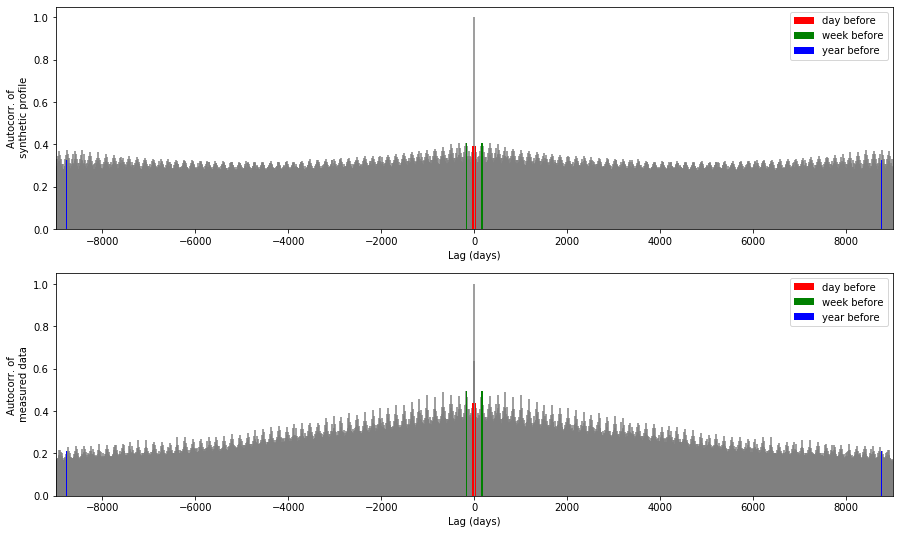

In [11]:
# Create the figure
fig, ax1 = plt.subplots(2, 1, figsize=(15, 3*3))
# Global parameters for the two subplots
xlim = [-9000,9000]
barwidth = 25

## Create artificially a dataset over several years
## by concatenating all the profiles
allProfiles = []
for p in np.arange(nb_profile):
    allProfiles = np.append(profiles['use'+str(p)].values, allProfiles)
    
## Plot autocorrelation for synthetic profile
lags1 = ax1[0].acorr(allProfiles, maxlags=9000, color='grey', zorder=0)
# Emphasis the day before, the week before and the year before
ax1[0].bar(lags1[0][np.where(abs(lags1[0]) == 24)[0]], lags1[1][np.where(abs(lags1[0]) == 24)[0]], color='red', width=barwidth, label='day before')
ax1[0].bar(lags1[0][np.where(abs(lags1[0]) == 7*24)[0]], lags1[1][np.where(abs(lags1[0]) == 7*24)[0]], color='green', width=barwidth, label='week before')
ax1[0].bar(lags1[0][np.where(abs(lags1[0]) == 365*24)[0]], lags1[1][np.where(abs(lags1[0]) == 365*24)[0]], color='blue', width=barwidth, label='year before')
# Add labels to autocorrelation plot
ax1[0].set_ylabel('Autocorr. of\n synthetic profile')
ax1[0].set_xlabel('Lag (days)')
ax1[0].set_xlim(xlim)
# Display the autocorrelation plot
ax1[0].legend()

## Plot autocorrelation for measured data
lags2 = ax1[1].acorr(buildingComplete.use, maxlags=9000, color='grey', zorder=0)
# Emphasis the day before, the week before and the year before
ax1[1].bar(lags2[0][np.where(abs(lags2[0]) == 24)[0]], lags2[1][np.where(abs(lags2[0]) == 24)[0]], color='red', width=barwidth, label='day before')
ax1[1].bar(lags2[0][np.where(abs(lags2[0]) == 7*24)[0]], lags2[1][np.where(abs(lags2[0]) == 7*24)[0]], color='green', width=barwidth, label='week before')
ax1[1].bar(lags2[0][np.where(abs(lags2[0]) == 365*24)[0]], lags2[1][np.where(abs(lags2[0]) == 365*24)[0]], color='blue', width=barwidth, label='year before')
# Add labels to autocorrelation plot
ax1[1].set_ylabel('Autocorr. of\n measured data')
ax1[1].set_xlabel('Lag (days)')
ax1[1].set_xlim(xlim)
# Display the autocorrelation plot
ax1[1].legend()

Zooming in on these figures gives a better idea of short-term autocorrelations.

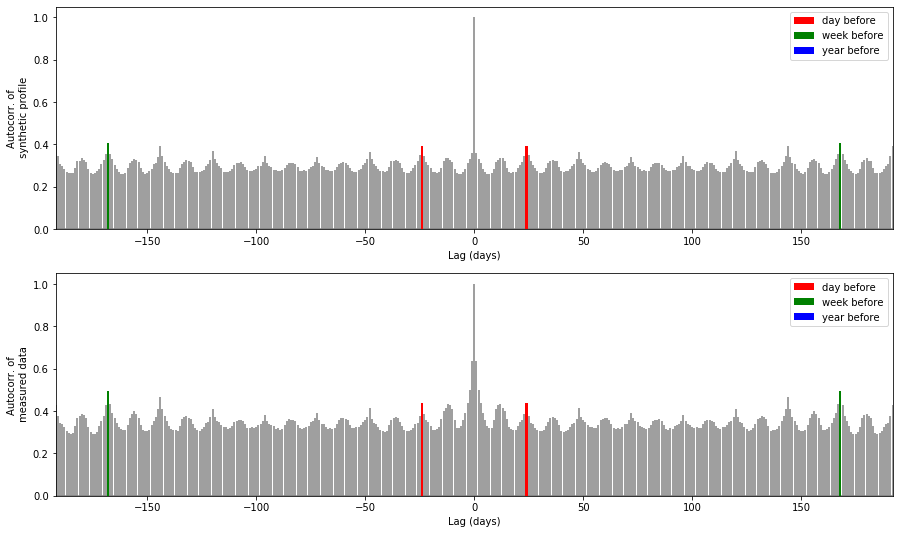

In [12]:
# Create the figure
fig, ax1 = plt.subplots(2, 1, figsize=(15, 3*3))
# Global parameters for the two subplots
xlim = [-8*24,8*24]
barwidth = 1

## Plot autocorrelation for synthetic profile
lags1 = ax1[0].acorr(allProfiles, maxlags=8760, color='grey', zorder=0)
# Emphasis the day before, the week before and the year before
ax1[0].bar(lags1[0][np.where(abs(lags1[0]) == 24)[0]], lags1[1][np.where(abs(lags1[0]) == 24)[0]], color='red', width=barwidth, label='day before')
ax1[0].bar(lags1[0][np.where(abs(lags1[0]) == 7*24)[0]], lags1[1][np.where(abs(lags1[0]) == 7*24)[0]], color='green', width=barwidth, label='week before')
ax1[0].bar(lags1[0][np.where(abs(lags1[0]) == 365*24)[0]], lags1[1][np.where(abs(lags1[0]) == 365*24)[0]], color='blue', width=barwidth, label='year before')
# Add labels to autocorrelation plot
ax1[0].set_ylabel('Autocorr. of\n synthetic profile')
ax1[0].set_xlabel('Lag (days)')
ax1[0].set_xlim(xlim)
# Display the autocorrelation plot
ax1[0].legend()

## Plot autocorrelation for measured data
lags2 = ax1[1].acorr(buildingComplete.use, maxlags=9000, color='grey', zorder=0)
# Emphasis the day before, the week before and the year before
ax1[1].bar(lags2[0][np.where(abs(lags2[0]) == 24)[0]], lags2[1][np.where(abs(lags2[0]) == 24)[0]], color='red', width=barwidth, label='day before')
ax1[1].bar(lags2[0][np.where(abs(lags2[0]) == 7*24)[0]], lags2[1][np.where(abs(lags2[0]) == 7*24)[0]], color='green', width=barwidth, label='week before')
ax1[1].bar(lags2[0][np.where(abs(lags2[0]) == 365*24)[0]], lags2[1][np.where(abs(lags2[0]) == 365*24)[0]], color='blue', width=barwidth, label='year before')
# Add labels to autocorrelation plot
ax1[1].set_ylabel('Autocorr. of\n measured data')
ax1[1].set_xlabel('Lag (days)')
ax1[1].set_xlim(xlim)
# Display the autocorrelation plot
ax1[1].legend()

<font color=green>Comments:</font>
- The model works quite well according to these feature: the global pattern of the autocorrelation plot is well reproduced.
- However autocorrelation from one year to another is overestimated by the model (beginning and end of the first graph).
- The correlation with previous hour is on the contrary underestimated by the model (lines on both sides of the central one). This is expected as this model does not take account of the previous hour. A [Markov Chain model](https://en.wikipedia.org/wiki/Markov_chain) would give better results in this case.

## Discrete Fourier transform
The discrete Fourier transform decomposes a signal into its sine and cosine components.  
Each component is described by its frequency and amplitude.  
Looking at the frequencies which have the highest amplitudes is another way to find periodic patterns in a time series.

The synthetic data over several years is used again here to perform the discrete Fourier transform.

**Remark:** The second graph is again a zoomed in version of the first.

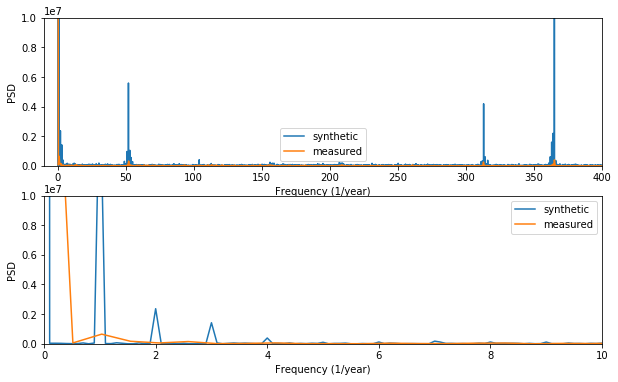

In [13]:
# Create the figure
fig2, ax2 = plt.subplots(2, 1, figsize=(10, 6))

## Synthetic profiles
# Compute the FFT of the signal
synthUse_fft = fft.fft(allProfiles)
# Compute the power spectral density (PWD)
synthUse_psd = np.abs(synthUse_fft) ** 2
# Compute the frequencies of the PWDs
timestep = 1/(365*24) # year based
fftfreq = fft.fftfreq(len(synthUse_psd), timestep)
i = fftfreq >= 0 # keep only the positive frequencies
# Plot the results
ax2[0].plot(fftfreq[i], synthUse_psd[i], label="synthetic")
ax2[1].plot(fftfreq[i], synthUse_psd[i], label="synthetic")

## Measurement data
# Compute the FFT of the signal
measUse_fft = fft.fft(buildingComplete.use)
# Compute the power spectral density (PWD)
measUse_psd = np.abs(measUse_fft) ** 2
# Compute the frequencies of the PWDs
timestep = 1/(365*24) # year based
fftfreq = fft.fftfreq(len(measUse_psd), timestep)
i = fftfreq >= 0 # keep only the positive frequencies
# Plot the results
ax2[0].plot(fftfreq[i], measUse_psd[i], label="measured")
ax2[1].plot(fftfreq[i], measUse_psd[i], label="measured")

# Format subplots
ax2[0].set_xlim(-10, 400)
ax2[0].set_ylim(0, 0.1e8)
ax2[0].set_ylabel('PSD')
ax2[0].set_xlabel('Frequency (1/year)')
ax2[0].legend()
ax2[1].set_xlim(0, 10) # the second one is a zoom from the first one
ax2[1].set_ylim(0, 0.1e8)
ax2[1].set_ylabel('PSD')
ax2[1].set_xlabel('Frequency (1/year)')
ax2[1].legend()

- Yearly trend corresponds to the frequency $f=1$.
- The frequency $f=2$ is related to a bi-yearly, i.e. seasonal trend.
- There is a peak at $f=52$ for weekly trend (accounted for by distinction between weekdays and weekends).
- The daily pattern is clearly visible for $f=365$.

<font color=green>Comments:</font>
- It seems that the model reproduces *too well* the different trends, i.e. the corresponding amplitudes are more significant than they should be.  
Again this implies that the model is too conservative. 